In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from functools import reduce
import matplotlib.pyplot as plt
from operator import mul
import collections
from tqdm import tqdm
from random import choice, shuffle

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16



# Среда

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # С…РѕРґ РїРµСЂРІРѕРіРѕ РёРіСЂРѕРєР°
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # РїСЂРѕРІРµСЂРёРј, РЅРµ Р·Р°РєРѕРЅС‡РёР»Р°СЃСЊ Р»Рё РёРіСЂР°
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):

            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Р РёСЃСѓРµРј РґРѕСЃРєСѓ СЃ РѕС†РµРЅРєР°РјРё РёР· СЃС‚СЂР°С‚РµРіРёРё pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Р”РµР»Р°РµРј С…РѕРґ, СЂРёСЃСѓРµРј РґРѕСЃРєСѓ'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("РЎС‚СЂР°С‚РµРіРёСЏ РЅРµ Р·РЅР°РµС‚, С‡С‚Рѕ РґРµР»Р°С‚СЊ...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''РРіСЂР°РµРј С‚РµСЃС‚РѕРІСѓСЋ РїР°СЂС‚РёСЋ РјРµР¶РґСѓ СЃС‚СЂР°С‚РµРіРёСЏРјРё РёР»Рё СЃРѕ СЃР»СѓС‡Р°Р№РЅС‹РјРё С…РѕРґР°РјРё, СЂРёСЃСѓРµРј С…РѕРґ РёРіСЂС‹'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("РљСЂРµСЃС‚РёРєРё РІС‹РёРіСЂР°Р»Рё!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("РќРѕР»РёРєРё РІС‹РёРіСЂР°Р»Рё!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

# Часть первая: крестики-нолики при помощи Q-обучения

Предлагается заполнить в матрице Q ходы противрочящее правилам большим отрицательным числом, это сильно уменьшит количество иитераций, нужных для обучения, так как модели не надо будет изучать в каком положении нельзя делать "запрещенные ходы".

In [6]:
def random_move(env):
    return choice(env.getEmptySpaces())

# def compute_policy_by_Q(Q):
#     out = collections.defaultdict(lambda: tuple([0,0]))
#     for s in Q.keys():
#         m = max(Q[s].items(), key=lambda x: x[1])[1]
#         out[s] = choice([i[0] for i in Q[s].items() if i[1] == m])
#     return out

def policy(Q, state):
    m = max(Q[state].items(), key=lambda x: x[1])[1]
    return choice([i[0] for i in Q[state].items() if i[1] == m])

def Q_learning_episode(env, Q, opponent, reward_dict, crosses, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    if crosses:
        s, a = env.getHash(), tuple(policy(Q, env.getHash())) if np.random.rand() > epsilon else tuple(random_move(env))
    else:
        observation, reward, done, info = env.step(opponent(env))
        s, a = env.getHash(), tuple(policy(Q, env.getHash())) if np.random.rand() > epsilon else tuple(random_move(env))

    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        reward = reward_dict[reward]

        if not done:
            observation, reward, done, info = env.step(opponent(env))
            reward = reward_dict[reward]

        if not done:
            s_prime, a_prime = env.getHash(), tuple(policy(Q, env.getHash())) if np.random.rand() > epsilon else tuple(random_move(env))
            Q[s][a] = Q[s][a] + alpha * (reward + gamma * max(Q[s_prime].values()) - Q[s][a])
            s, a = s_prime, a_prime
        else:
            Q[s][a] = Q[s][a] + alpha * (reward - Q[s][a])

        if done:
            return reward

def create_inital_Q(env):
    env.reset()
    to_many_hashes = ['']
    default_hash = env.getHash()
    for i in range(len(default_hash)):
        to_many_hashes = [j + c for c in to_many_hashes for j in ['0', '1', '2']]
    all_hashes = [c for c in to_many_hashes if (c.count('2') - c.count('0')) in [1,0] ]

    all_actions = env.getEmptySpaces()

    Q = dict.fromkeys(all_hashes)
    tuple_all_actions = [tuple(c) for c in all_actions]
    dict_all = dict.fromkeys(tuple_all_actions)
    for hash_ in tqdm(all_hashes):
        Q[hash_] = dict_all.copy()
        for action in all_actions:
            pos = action[0] * env.n_cols + action[1]
            action_tuple = tuple(action)
            if hash_[pos] == '1':
                Q[hash_][action_tuple] = 0
            else:
                Q[hash_][action_tuple] = -1000
    return Q

def Q_learning(env, Q, opponent, crosses, total_episodes, alpha, epsilon, gamma):

    result = []
    rew = []

    reward_dict = {}
    if crosses:
        reward_dict[1] = 1
        reward_dict[-10] = -10
        reward_dict[-1] = -1
        reward_dict[0] = 0
    else:
        reward_dict[1] = -1
        reward_dict[-10] = -10
        reward_dict[-1] = 1
        reward_dict[0] = 0

    for n in tqdm(range(total_episodes)):
        rew.append(Q_learning_episode(env, Q, opponent, reward_dict, crosses, alpha=alpha, epsilon=epsilon, gamma=gamma))

        if n % 100 == 0 and n > 0:
            result.append(np.mean(rew))
            rew = []

    return result, env, Q

# 3 на 3

In [7]:
n_rows = 3
n_cols = 3
n_win = 3
total_episodes = 10000
alpha = 0.01
epsilon = 0.2
gamma = 1

## Обучим крестики

In [8]:
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
Q = create_inital_Q(env)

100%|██████████| 6046/6046 [00:00<00:00, 33112.44it/s]


In [9]:
result_cross, env_cross, Q_cross  = Q_learning(env, Q.copy(), random_move, crosses=True, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 10000/10000 [00:04<00:00, 2277.07it/s]


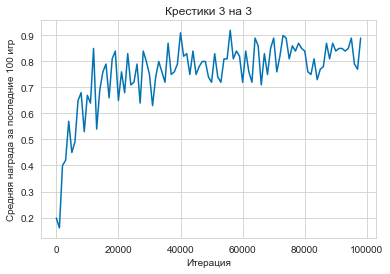

In [12]:
plt.plot([i*1000 for i in range(len(result_cross))], result_cross)
plt.title("Крестики 3 на 3")
plt.xlabel('Итерация')
plt.ylabel('Средняя награда за последние 100 игр')
plt.show()

Учитывая, что за поражение мы получаем -1, то мы вполне обучились обыгрывать случайную модель.

## Обучим нолики

In [11]:
result_zer, env_zer, Q_zer  = Q_learning(env, Q.copy(), random_move, crosses=False, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 10000/10000 [00:04<00:00, 2115.08it/s]


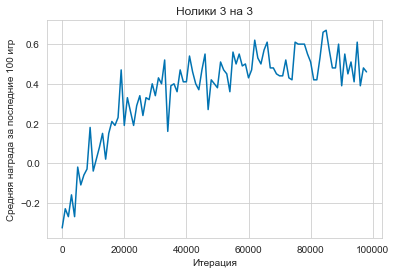

In [13]:
plt.plot([i*1000 for i in range(len(result_zer))], result_zer)
plt.title("Нолики 3 на 3")
plt.xlabel('Итерация')
plt.ylabel('Средняя награда за последние 100 игр')
plt.show()

# 4 на 4

In [17]:
n_rows = 4
n_cols = 4
n_win = 3
total_episodes = 100000
alpha = 0.01
epsilon = 0.2
gamma = 1

При переходе от поля 3 на 3 количество вариантов резко возрасло и код, который бодро работал на 3 на 3 стал оценивать время совершения 1000 итераций на 4 на 4 в 43 часа..., поэтому его пришлось почти полностью долго переписывать, что стало неприятной неожиданностью.

## Обучим крестики

In [9]:
env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
Q = create_inital_Q(env)

100%|██████████| 10165779/10165779 [12:01<00:00, 14088.92it/s]


In [18]:
result_cross, env_cross, Q_cross  = Q_learning(env, Q.copy(), random_move, crosses=True, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 100000/100000 [01:30<00:00, 1109.70it/s]


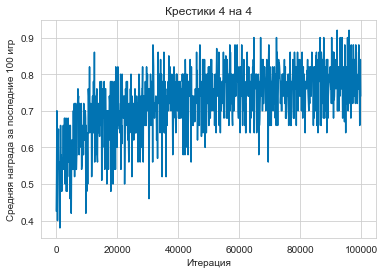

In [20]:
plt.plot([i*100 for i in range(len(result_cross))], result_cross)
plt.title("Крестики 4 на 4")
plt.xlabel('Итерация')
plt.ylabel('Средняя награда за последние 100 игр')
plt.show()

## Обучим нолики

100%|██████████| 100000/100000 [02:08<00:00, 779.35it/s]


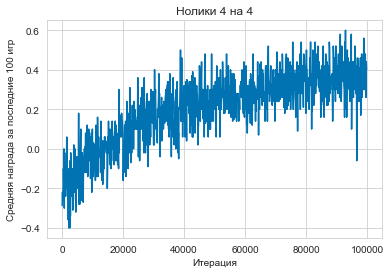

In [21]:
result_zer, env_zer, Q_zer  = Q_learning(env, Q.copy(), random_move, crosses=False, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma)

plt.plot([i*100 for i in range(len(result_zer))], result_zer)
plt.title("Нолики 4 на 4")
plt.xlabel('Итерация')
plt.ylabel('Средняя награда за последние 100 игр')
plt.show()

К сожалению, из-за количества времени потраченового на оптимизацию, что бы Qlearning нормально заработал на полях побольше 3x3 и загрузки по другим предметам остальные пункты выполниить не удалось :(